<a href="https://colab.research.google.com/github/RashmikaReddy/Quora-Question-Similarity/blob/main/Quora_Question_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/QuoraQuestionSimilarity/questions.csv")

In [ ]:

print("Number of data points:",df.shape[0])

NameError: ignored

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


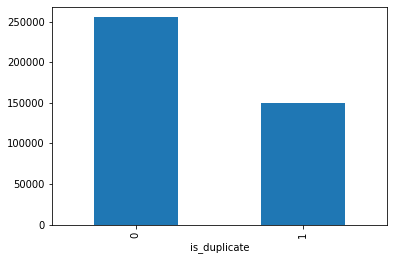

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()


In [ ]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))


~> Total number of question pairs for training:
   404351


In [ ]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [ ]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()


In [ ]:
pair_duplicates

,qid1,qid2,is_duplicate
0,1,2,1
1,3,4,1
2,5,6,1
3,7,8,1
4,9,10,1
...,...,...,...
404343,789792,789793,1
404344,789794,789795,1
404345,789796,789797,1
404346,789798,789799,1


In [ ]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105796  105796  209841  209842    How can I develop android app?   
201871  201871  398348  398349  How can I create an Android app?   
363416  363416  711434  711435                               NaN   

                                                question2  is_duplicate  
105796                                                NaN             0  
201871                                                NaN             0  
363416  My Chinese name is Haichao Yu. What English na...             0  


In [ ]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []



**Basic Feature Extraction (before cleaning)**
Let us now construct a few features like:

*   ____freq_qid1____ = Frequency of qid1's
*   ____freq_qid2____ = Frequency of qid2's
*   ____q2len____ = Length of q2
*   ____q2len____ = Length of q2
*   ____q1_n_words____ = Number of words in Question 1
*   ____q2_n_words____ = Number of words in Question 2
*   ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
*   ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
*   ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
*   ____word_share____ = (word_common)/(word_Total)
*   ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2
*   ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2


In [ ]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')


In [ ]:
df.loc[df['freq_qid1'] > 1]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1
468,468,937,938,What are some good places to learn mountaineer...,What are some good mountaineering institutes f...,1,2
518,518,1037,1038,What are scraping techniques?,What are some good free web scrapers / scrapin...,1,2
519,519,1039,1040,I am 29Y old. I have diabetic Type 2. Recently...,Where can I find the best Security Cameras?,0,2
544,544,1089,1090,What can you do in lucid dreams?,How was your experience of Lucid dreaming?,1,2
546,546,1093,1094,Is it possible to do CA after 12th Science?,What should be done further to apply for Ph.D ...,0,3
...,...,...,...,...,...,...,...
404134,404134,170149,789382,"iPhones, especially iPhone 4, have great video...",How can I add a non-iPhone video to the iPhone...,0,2
404207,404207,371147,343683,How does Facebook choose who shows up in the c...,How are the list of friends' faces displayed i...,0,5
404220,404220,572987,789544,How can I learn more about CRM?,How can we learn more about IT?,0,2
404248,404248,737659,789599,How can I get more listeners on SoundCloud?,How do I get more followers on Instagram?,0,2


In [ ]:
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [ ]:
def normalized_word_Common(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)


In [ ]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])


In [ ]:
df.head()


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


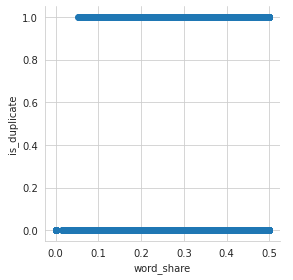

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(df, size=4) \
   .map(plt.scatter, "word_share", "is_duplicate") \
   .add_legend()
plt.show()


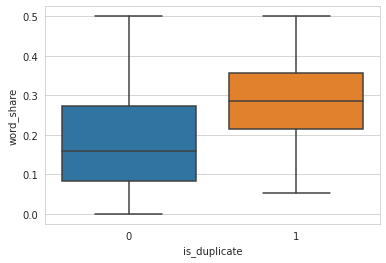

In [ ]:
sns.boxplot(data=df, x="is_duplicate", y="word_share")



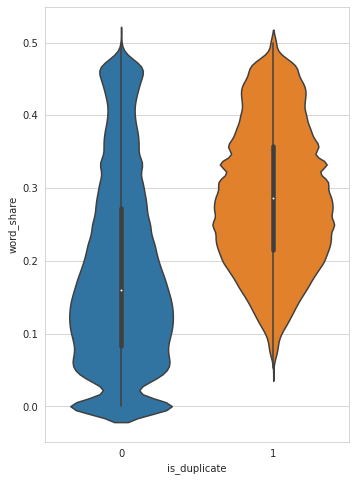

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(data=df, x="is_duplicate", y="word_share")


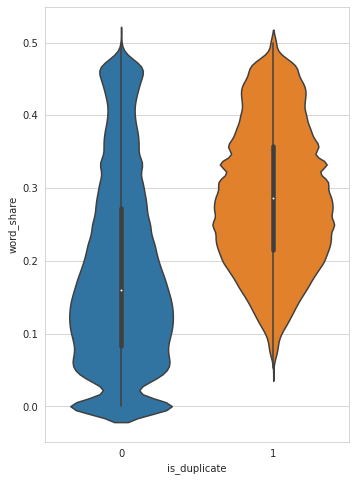

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


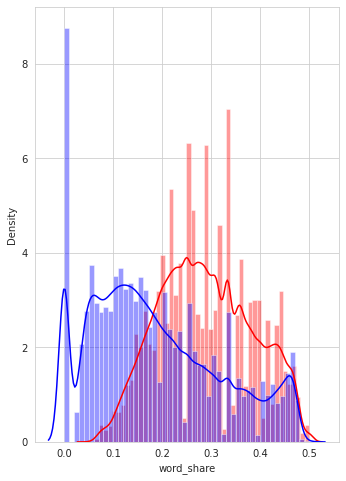

In [ ]:
plt.figure(figsize=(12, 8))


plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

**Preprocessing of Text**

Removing html tags

Removing Punctuations

Performing stemming

Removing Stopwords

Expanding contractions etc.

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.manifold import TSNE

In [ ]:
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    


LookupError: ignored

In [ ]:
print(type(''))

<class 'str'>


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
import spacy

In [ ]:
df_tfidf = pd.read_csv("/content/drive/MyDrive/QuoraQuestionSimilarity/questions.csv")

In [ ]:
df_tfidf['question1'] = df_tfidf['question1'].apply(lambda x: str(x))
df_tfidf['question2'] = df_tfidf['question2'].apply(lambda x: str(x))

In [ ]:
df_tfidf.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df_tfidf = df_tfidf.dropna(axis=0)

In [ ]:
nan_rows = df_tfidf[df_tfidf.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df_tfidf['question1']) + list(df_tfidf['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["This is very strange",
          "This is very nice"]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
print(dict(zip(vectorizer.get_feature_names(), idf)))

{'is': 1.0, 'nice': 1.4054651081081644, 'strange': 1.4054651081081644, 'this': 1.0, 'very': 1.0}


In [ ]:
word2tfidf

{'00': 10.049310117133967,
 '000': 7.304741907226361,
 '0000': 13.910039828174563,
 '000000': 13.910039828174563,
 '00000000': 13.910039828174563,
 '0000000000': 13.504574720066397,
 '0000001': 13.910039828174563,
 '00000074': 13.910039828174563,
 '0000021210': 13.910039828174563,
 '00001': 13.910039828174563,
 '0001': 13.910039828174563,
 '0002': 13.910039828174563,
 '000INR': 13.910039828174563,
 '000K': 13.910039828174563,
 '000Rs': 12.811427539506452,
 '000USD': 13.910039828174563,
 '000WebHost': 13.910039828174563,
 '000ft': 13.910039828174563,
 '000rs': 13.910039828174563,
 '000s': 13.910039828174563,
 '000webhost': 13.910039828174563,
 '001': 12.811427539506452,
 '0015': 13.910039828174563,
 '0019': 13.910039828174563,
 '002': 13.216892647614618,
 '0021': 13.910039828174563,
 '0035': 13.910039828174563,
 '003SC': 13.910039828174563,
 '005': 13.910039828174563,
 '0051': 13.504574720066397,
 '007': 13.504574720066397,
 '008': 13.504574720066397,
 '008801703772104': 13.910039828174

After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [ ]:
import en_core_web_sm
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for question1 in tqdm(list(df_backup['question1'][0:2])):
    doc1 = nlp(question1)
    print("doc1 is ",doc1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    #print("mean_vec1 is ",mean_vec1)
    #print("size of mean_vec1 is", len(mean_vec1))
    count = 0
    for word1 in doc1:
        count = count + 1
        # word2vec
        print("word1 is",word1)
        vec1 = word1.vector
        #print("vect1 is",vec1)
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
            print("idf is",idf)
        except:
            idf = 0
            print("idf is",idf)
        # compute final vec
        mean_vec = vec1 * idf
        print("size of vector ",len(mean_vec))
        if count == 1:
          mean_vec1 = mean_vec
        #print("mean_vec is",mean_vec)
        #print("size of mean_vec is", len(mean_vec))
        if count > 1:
          mean_vec1 = mean_vec + mean_vec1
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
print("vecs1 size is",len(vecs1))
#df['q1_feats_m'] = list(vecs1)


KeyError: ignored

In [ ]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for question1 in tqdm(list(df_tfidf['question1'])):
    doc1 = nlp(question1)
    print("doc1 is ",doc1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    #print("mean_vec1 is ",mean_vec1)
    #print("size of mean_vec1 is", len(mean_vec1))
    count = 0
    for word1 in doc1:
        count = count + 1
        # word2vec
        #print("word1 is",word1)
        vec1 = word1.vector
        #print("vect1 is",vec1)
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
            #print("idf is",idf)
        except:
            idf = 0
            #print("idf is",idf)
        # compute final vec
        mean_vec = vec1 * idf
        if count == 1:
          mean_vec1 = mean_vec
        #print("mean_vec is",mean_vec)
        #print("size of mean_vec is", len(mean_vec))
        if count > 1:
          mean_vec1 = mean_vec + mean_vec1
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
print("vecs1 size is",len(vecs1))
df_tfidf['q1_feats_m'] = list(vecs1)

 90%|████████▉ | 362859/404351 [38:42<05:05, 135.67it/s]

In [ ]:
vecs2 = []
for question2 in tqdm(list(df_tfidf['question2'])):
    doc2 = nlp(question2) 
    count = 0
    for word2 in doc2:
        count = count + 1
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec = vec2 * idf
        if count == 1:
          mean_vec2 = mean_vec
        if count > 1:
          mean_vec2 = mean_vec + mean_vec2
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
print("vecs1 size is",len(vecs2))
df_tfidf['q2_feats_m'] = list(vecs2)

100%|██████████| 404351/404351 [42:10<00:00, 159.82it/s]


vecs1 size is 404351


In [ ]:
#Saving Backup dataframe 
df_backup = df_tfidf
df_tfidf = df_tfidf.drop(['question1','question2'],axis=1)
df_q1 = pd.DataFrame(df_tfidf.q1_feats_m.values.tolist(), index= df_tfidf.index)
df_q2 = pd.DataFrame(df_tfidf.q2_feats_m.values.tolist(), index= df_tfidf.index)
df2_q1 = pd.DataFrame(df_backup.q1_feats_n.values.tolist(), index= df_backup.index)


KeyError: ignored

In [ ]:
df2_q1 = pd.DataFrame(df_backup.q1_feats_n.values.tolist(), index= df_backup.index)


AttributeError: ignored

In [ ]:
import en_core_web_sm
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()

# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for question1 in tqdm(list(df_backup['question1'][0:2])):
    doc1 = nlp(question1)
    print("doc1 is ",doc1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    #print("mean_vec1 is ",mean_vec1)
    #print("size of mean_vec1 is", len(mean_vec1))
    count = 0
    for word1 in doc1:
        count = count + 1
        # word2vec
        print("word1 is",word1)
        vec1 = word1.vector
        #print("vect1 is",vec1)
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
            print("idf is",idf)
        except:
            idf = 0
            print("idf is",idf)
        # compute final vec
        mean_vec = vec1 * idf
        print("size of vector ",len(mean_vec))
        if count == 1:
          mean_vec1 = mean_vec
        #print("mean_vec is",mean_vec)
        #print("size of mean_vec is", len(mean_vec))
        if count > 1:
          mean_vec1 = mean_vec + mean_vec1
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
print("vecs1 size is",len(vecs1))
#df['q1_feats_m'] = list(vecs1)


100%|██████████| 2/2 [00:00<00:00, 24.03it/s]

doc1 is  What is the step by step guide to invest in share market in india?
word1 is What
idf is 1.9903367834307029
size of vector  96
word1 is is
idf is 2.3584082054889217
size of vector  96
word1 is the
idf is 1.982336090886931
size of vector  96
word1 is step
idf is 8.245344742226408
size of vector  96
word1 is by
idf is 4.883321858725383
size of vector  96
word1 is step
idf is 8.245344742226408
size of vector  96
word1 is guide
idf is 9.073757921223084
size of vector  96
word1 is to
idf is 2.5008040532467772
size of vector  96
word1 is invest
idf is 7.209308718626752
size of vector  96
word1 is in
idf is 2.5273996017213696
size of vector  96
word1 is share
idf is 7.521478422628933
size of vector  96
word1 is market
idf is 6.854295671478976
size of vector  96
word1 is in
idf is 2.5273996017213696
size of vector  96
word1 is india
idf is 7.2298126988244595
size of vector  96
word1 is ?
idf is 0
size of vector  96
doc1 is  What is the story of Kohinoor (Koh-i-Noor) Diamond?
word1 is W

In [ ]:
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_backup['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_backup['q1_feats_n'] = list(vecs1)


100%|██████████| 404351/404351 [42:55<00:00, 157.02it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(df_tfidf['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_backup['q2_feats_n'] = list(vecs2)

100%|██████████| 404351/404351 [42:54<00:00, 157.08it/s]


In [ ]:
vecs1

In [ ]:
print(vecs1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
df_backup['q1_feats_n'] = list(vecs1)

In [ ]:
df_backup.head()

,id,qid1,qid2,is_duplicate,q1_feats_m,q2_feats_m,q1_feats_n
0,0,1,2,0,-0.453979,-0.306317,"[28.506468951702118, -6.671606227755547, 27.93..."
1,1,3,4,0,-0.124816,-0.827472,"[80.92098835110664, 14.522570509463549, 8.7469..."
2,2,5,6,0,-0.568870,-0.381551,"[16.304425358772278, 10.469326231628656, -16.1..."
3,3,7,8,0,-0.583392,-0.447523,"[25.438808172941208, 60.48770892620087, -18.73..."
4,4,9,10,0,-0.122668,-0.393252,"[89.66106440126896, -33.57165667414665, 32.714..."


In [ ]:
df2_q1 = pd.DataFrame(df_backup.q1_feats_n.values.tolist(), index= df_backup.index)
df2_q2 = pd.DataFrame(df_backup.q12_feats_n.values.tolist(), index= df_backup.index)



In [ ]:
df2_q2 = pd.DataFrame(df_backup.q2_feats_n.values.tolist(), index= df_backup.index)


In [ ]:
df2_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,28.506469,-6.671606,27.932229,-35.300765,-13.585053,2.801369,-34.126474,-39.730918,13.899966,7.647767,...,21.430713,-1.584267,-26.080581,14.414236,-43.693945,-52.159622,39.670649,65.209805,3.652120,2.128327
1,80.920988,14.522571,8.746974,-10.626378,-32.862901,42.648195,-49.312518,-4.615529,24.387982,-10.314084,...,9.534635,-9.775774,-67.355558,7.882584,7.294476,-46.185620,-18.570530,47.658440,28.386043,26.411984
2,16.304425,10.469326,-16.121847,-2.034328,-12.672344,-3.326023,-4.964594,-40.803293,19.396723,0.459409,...,36.501738,14.438482,5.828492,36.516953,-31.185466,-33.912869,-0.511550,-18.043760,6.462252,-8.763957
3,25.438808,60.487709,-18.734199,-17.649383,10.606319,34.267469,-7.642706,-19.064217,36.765000,-18.291195,...,-17.920239,17.956820,-11.392471,6.169595,1.400949,10.196095,32.519638,-20.275582,36.924826,-12.491223
4,89.661064,-33.571657,32.714265,-32.019273,38.479265,14.766335,-15.869359,-72.610924,86.241565,-5.095696,...,-43.476448,1.631191,-22.071738,35.274899,34.909688,-44.467408,14.255925,29.884291,32.550248,49.328167


In [ ]:
df2_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,28.506469,-6.671606,27.932229,-35.300765,-13.585053,2.801369,-34.126474,-39.730918,13.899966,7.647767,...,21.430713,-1.584267,-26.080581,14.414236,-43.693945,-52.159622,39.670649,65.209805,3.652120,2.128327
1,80.920988,14.522571,8.746974,-10.626378,-32.862901,42.648195,-49.312518,-4.615529,24.387982,-10.314084,...,9.534635,-9.775774,-67.355558,7.882584,7.294476,-46.185620,-18.570530,47.658440,28.386043,26.411984
2,16.304425,10.469326,-16.121847,-2.034328,-12.672344,-3.326023,-4.964594,-40.803293,19.396723,0.459409,...,36.501738,14.438482,5.828492,36.516953,-31.185466,-33.912869,-0.511550,-18.043760,6.462252,-8.763957
3,25.438808,60.487709,-18.734199,-17.649383,10.606319,34.267469,-7.642706,-19.064217,36.765000,-18.291195,...,-17.920239,17.956820,-11.392471,6.169595,1.400949,10.196095,32.519638,-20.275582,36.924826,-12.491223
4,89.661064,-33.571657,32.714265,-32.019273,38.479265,14.766335,-15.869359,-72.610924,86.241565,-5.095696,...,-43.476448,1.631191,-22.071738,35.274899,34.909688,-44.467408,14.255925,29.884291,32.550248,49.328167


In [ ]:
df_q1.head()

,0,id
0,-0.453979,0
1,-0.124816,1
2,-0.568870,2
3,-0.583392,3
4,-0.122668,4


In [ ]:
len(df_q1)

404351

In [ ]:
len(df_q2)

404351

In [ ]:
# Questions 2 tfidf weighted word2vec
df_q2.head()

,0,id
0,-0.306317,0
1,-0.827472,1
2,-0.381551,2
3,-0.447523,3
4,-0.393252,4


In [ ]:
df_tfidf.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df2_q1['id']=df_tfidf['id']
df2_q2['id']=df_tfidf['id']

In [ ]:
df1  = df_backup.merge(df2_q1, on='id',how='left')
result  = df1.merge(df2_q2, on='id',how='left')
result.to_csv('/content/drive/MyDrive/QuoraQuestionSimilarity/final_features.csv')

KeyboardInterrupt: ignored

In [ ]:
result  = df1.merge(df2_q2, on='id',how='left')


In [ ]:
result.head()

,id,qid1,qid2,is_duplicate,q1_feats_m,q2_feats_m,q1_feats_n,q2_feats_n,0_x,1_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,0,-0.453979,-0.306317,"[28.506468951702118, -6.671606227755547, 27.93...","[24.076550900936127, -4.3290591686964035, 16.4...",28.506469,-6.671606,...,28.155096,1.356869,-11.827103,11.047405,-46.352901,-48.182210,43.841782,34.814798,9.035392,-10.400160
1,1,3,4,0,-0.124816,-0.827472,"[80.92098835110664, 14.522570509463549, 8.7469...","[70.50240159034729, 22.790661334991455, 2.4590...",80.920988,14.522571,...,9.848394,-6.027403,-41.090880,14.712551,-2.298972,-41.454022,-8.049691,32.257644,49.438164,7.736112
2,2,5,6,0,-0.568870,-0.381551,"[16.304425358772278, 10.469326231628656, -16.1...","[-4.7852097153663635, 25.61722220480442, 32.28...",16.304425,10.469326,...,17.235841,-16.021437,11.371580,38.165807,-58.872692,-58.695058,25.353697,-8.444090,18.219774,4.178136
3,3,7,8,0,-0.583392,-0.447523,"[25.438808172941208, 60.48770892620087, -18.73...","[8.96544498205185, 52.53073215484619, -3.67935...",25.438808,60.487709,...,-0.332932,2.494465,13.688828,14.936408,-38.073515,-27.147964,-10.721139,-11.845747,7.745904,-38.724691
4,4,9,10,0,-0.122668,-0.393252,"[89.66106440126896, -33.57165667414665, 32.714...","[32.099950075149536, -15.163292646408081, -2.5...",89.661064,-33.571657,...,9.265036,6.865467,-24.869680,18.216276,-8.753954,-22.904326,24.035716,-9.199441,23.657751,0.067455


In [ ]:
result = result.drop(['q1_feats_m','q2_feats_m'],axis=1)

In [ ]:
result.to_csv('/content/drive/MyDrive/QuoraQuestionSimilarity/final_csv.csv')

In [ ]:
result = result.drop(['q1_feats_n','q2_feats_n'],axis=1)

In [ ]:
result.head()

,id,qid1,qid2,is_duplicate,0_x,1_x,2_x,3_x,4_x,5_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,0,28.506469,-6.671606,27.932229,-35.300765,-13.585053,2.801369,...,28.155096,1.356869,-11.827103,11.047405,-46.352901,-48.182210,43.841782,34.814798,9.035392,-10.400160
1,1,3,4,0,80.920988,14.522571,8.746974,-10.626378,-32.862901,42.648195,...,9.848394,-6.027403,-41.090880,14.712551,-2.298972,-41.454022,-8.049691,32.257644,49.438164,7.736112
2,2,5,6,0,16.304425,10.469326,-16.121847,-2.034328,-12.672344,-3.326023,...,17.235841,-16.021437,11.371580,38.165807,-58.872692,-58.695058,25.353697,-8.444090,18.219774,4.178136
3,3,7,8,0,25.438808,60.487709,-18.734199,-17.649383,10.606319,34.267469,...,-0.332932,2.494465,13.688828,14.936408,-38.073515,-27.147964,-10.721139,-11.845747,7.745904,-38.724691
4,4,9,10,0,89.661064,-33.571657,32.714265,-32.019273,38.479265,14.766335,...,9.265036,6.865467,-24.869680,18.216276,-8.753954,-22.904326,24.035716,-9.199441,23.657751,0.067455


In [ ]:
result = result.drop(['id','qid1','qid2'], axis=1)


In [ ]:
result.head()

,is_duplicate,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,28.506469,-6.671606,27.932229,-35.300765,-13.585053,2.801369,-34.126474,-39.730918,13.899966,...,28.155096,1.356869,-11.827103,11.047405,-46.352901,-48.182210,43.841782,34.814798,9.035392,-10.400160
1,0,80.920988,14.522571,8.746974,-10.626378,-32.862901,42.648195,-49.312518,-4.615529,24.387982,...,9.848394,-6.027403,-41.090880,14.712551,-2.298972,-41.454022,-8.049691,32.257644,49.438164,7.736112
2,0,16.304425,10.469326,-16.121847,-2.034328,-12.672344,-3.326023,-4.964594,-40.803293,19.396723,...,17.235841,-16.021437,11.371580,38.165807,-58.872692,-58.695058,25.353697,-8.444090,18.219774,4.178136
3,0,25.438808,60.487709,-18.734199,-17.649383,10.606319,34.267469,-7.642706,-19.064217,36.765000,...,-0.332932,2.494465,13.688828,14.936408,-38.073515,-27.147964,-10.721139,-11.845747,7.745904,-38.724691
4,0,89.661064,-33.571657,32.714265,-32.019273,38.479265,14.766335,-15.869359,-72.610924,86.241565,...,9.265036,6.865467,-24.869680,18.216276,-8.753954,-22.904326,24.035716,-9.199441,23.657751,0.067455


In [ ]:
result=result.drop(['is_duplicate'], axis=1)


In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404351 entries, 0 to 404350
Columns: 192 entries, 0_x to 95_y
dtypes: float64(192)
memory usage: 595.4 MB


In [ ]:
result = pd.read_csv('/content/drive/MyDrive/QuoraQuestionSimilarity/final_csv.csv')


In [ ]:
cols = list(result.columns)
result = pd.DataFrame(np.array(result.values,dtype=np.float64),columns=cols)

In [ ]:
y_true = result['is_duplicate']
y_true = list(map(int, y_true.values))


In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.3,random_state=13)


In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283045, 197)
Number of data points in test data : (121306, 197)


In [ ]:
#Playing with estimators in RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

estimators = [100]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

estimators =  100 Train Log Loss  0.027114656438045674 Test Log Loss  0.07582365690100298


KeyboardInterrupt: ignored

Depth =  5 Train Log Loss  0.34932956636495666 Test Log Loss  0.3496920994813902
Depth =  10 Train Log Loss  0.22047365221024265 Test Log Loss  0.22494689899259773
Depth =  12 Train Log Loss  0.19742866323351818 Test Log Loss  0.20733317027497
Depth =  15 Train Log Loss  0.11549562236404635 Test Log Loss  0.13423380331022475
Depth =  20 Train Log Loss  0.06783716884219185 Test Log Loss  0.10594303920079494


Text(0, 0.5, 'Log Loss')

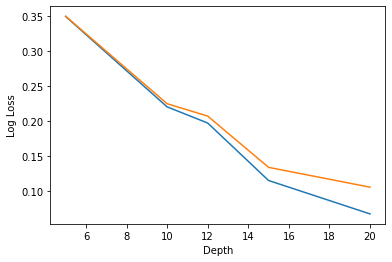

In [ ]:
#Playing with depth in Random Forest Classifier
Depth = [5,10,12,15,20]
test_scores = []
train_scores = []
for i in Depth:
    clf = RFC(n_estimators=100,max_depth=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Depth = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(Depth,train_scores,label='Train Log Loss')
plt.plot(Depth,test_scores,label='Test Log Loss')
plt.xlabel('Depth') 
plt.ylabel('Log Loss')

estimators =  100 Train Log Loss  2.788533124886852e-05 Test Log Loss  2.7885329155500065e-05


Text(0, 0.5, 'Log Loss')

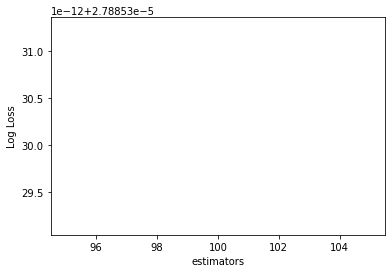

In [ ]:
#Exploring XgBoost after RandomForestClassifier
import xgboost as xgb

estimators = [100]
test_scores = []
train_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=12,learning_rate=0.1,n_estimators=100,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')


In [ ]:
print(predict_y)

[[2.9802322e-05 9.9997020e-01]
 [9.9997324e-01 2.6751673e-05]
 [9.9997324e-01 2.6751673e-05]
 ...
 [9.9997324e-01 2.6751673e-05]
 [9.9997324e-01 2.6751673e-05]
 [2.9802322e-05 9.9997020e-01]]


In [ ]:
print(y_train)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 

In [ ]:
print(y_test)

[1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 

In [ ]:
print(predict_actual)

[1 0 0 ... 0 0 1]


In [ ]:
from sklearn.metrics import f1_score, classification_report, accuracy_score


#print('training score:', f1_score(y_train, #.predict(X_train), average='macro'))
predict_actual = clf.predict(X_test)
print('validation score:', f1_score(y_test, predict_actual, average='macro'))
print(classification_report(y_test, predict_actual))

validation score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76514
           1       1.00      1.00      1.00     44792

    accuracy                           1.00    121306
   macro avg       1.00      1.00      1.00    121306
weighted avg       1.00      1.00      1.00    121306

